In [2]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import halophot
from halophot.halo_tools import *
from k2sc import cdpp 

import poppy
from scipy.interpolate import interp2d
import MegaScreen

fft, fftshift = np.fft.fft, np.fft.fftshift
fft2 = np.fft.fft2

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(12.0,8.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [3]:
r0=20.
L0=1e4
diameter=128
dx=10. # how many L0 do you move from frame to frame 
pixelsize= 0.1

nx, ny = diameter, diameter
x = np.arange(diameter)*pixelsize
x -= np.median(x)
xx, yy = np.meshgrid(x,x)
rr = np.sqrt((xx)**2. + (yy)**2.)

generator=MegaScreen.MegaScreen(r0,L0,windowShape=[diameter,diameter],dx=dx,theta=np.pi/3)


((0.0, 0.0), [128, 128], 0.03125)
((0.0, 0.0), [128, 128], 1.0)


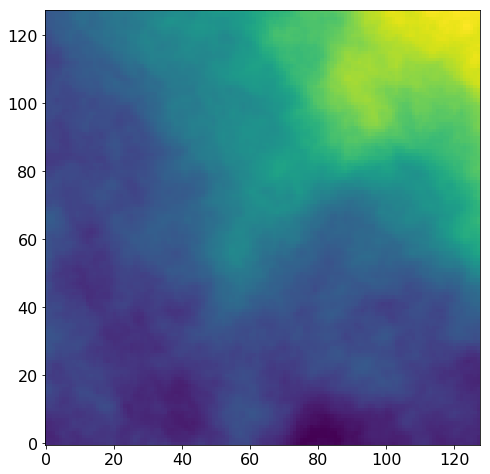

In [4]:
screen = next(generator)
plt.imshow(screen)

In [5]:
# # export videos of this 
# import imageio

# to_write = [(next(generator)) *256 for j in range(1024)]
# imageio.mimwrite('screens.mp4', to_write, fps = 64)


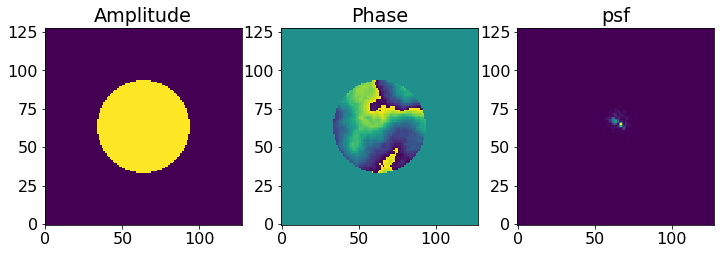

In [6]:
screen = next(generator)
pupil = np.ones_like(screen,dtype='complex')
pupil *= np.exp(1.j*screen)
pupil[rr>3.] = 0.

f, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(np.abs(pupil))
ax1.set_title('Amplitude')

ax2.imshow(np.angle(pupil))
ax2.set_title('Phase')

psf = np.abs(fftshift(fft2(pupil)))**2.

ax3.imshow(psf)
ax3.set_title('psf');

In [7]:
%%time 

ncad = 1024
psfs = np.ones((diameter,diameter, ncad))

for j in range(ncad):
    screen = next(generator)
    pupil = np.ones_like(screen,dtype='complex')

    pupil *= np.exp(1.j*screen)
    pupil[rr>3.] = 0.

    psf = np.abs(fftshift(fft2(pupil)))**2.

    psfs[:,:,j] = psf

CPU times: user 8.73 s, sys: 73.5 ms, total: 8.8 s
Wall time: 8.82 s


In [8]:
# check normalization
fluxes = np.zeros(ncad)
for j in range(ncad):
    fluxes[j] = psfs[:,:,j].sum()

print np.std(fluxes)

# plt.plot(fluxes)
    
psfs /= np.nanmedian(fluxes)
fluxes /=np.nanmedian(fluxes)

4.697181517684836e-09


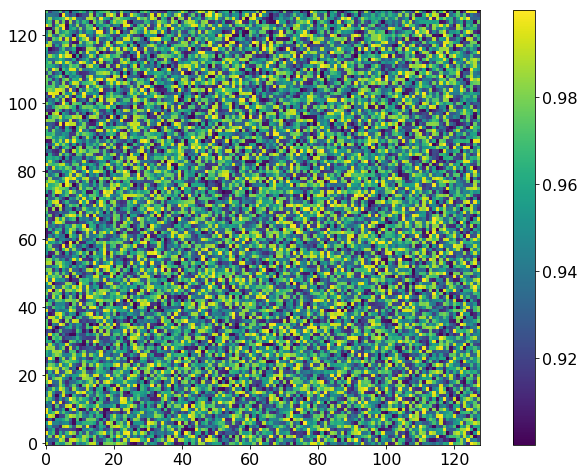

In [9]:
sensitivity = 1.0 - 0.1*np.random.rand(psf.shape[0],psf.shape[1])
plt.imshow(sensitivity,interpolation='none')
plt.colorbar()

Text(0.5,1,u'PSF $\\times$ PRF')

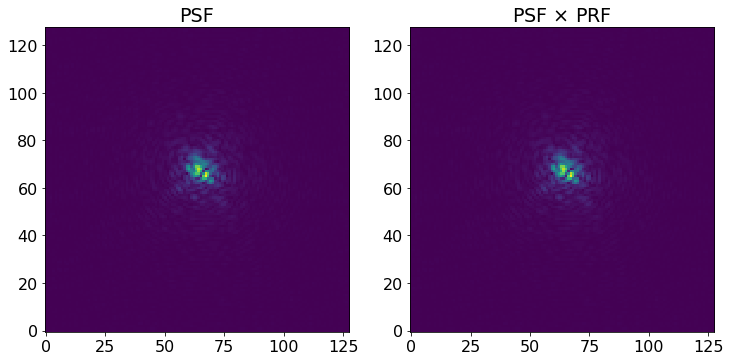

In [10]:
# generate images degraded by the pixel response function
images = sensitivity[:,:,np.newaxis]*psfs

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(psfs[:,:,0]**0.5,interpolation="none")
ax1.set_title('PSF')

ax2.imshow(images[:,:,0]**0.5,interpolation="none")
ax2.set_title(r'PSF $\times$ PRF')


In [11]:
# # export videos of this 
# import imageio

# to_write = [(images[:,:,j]/np.max(images[:,:,j]))**0.5 *256 for j in range(images.shape[2])]
# imageio.mimwrite('psf_video.mp4', to_write, fps = 64)


In [12]:
fluxes_meas = np.zeros(ncad)

for j in range(ncad):
    fluxes_meas[j] = images[nx/4:7*nx/4,nx/4:7*nx/4,j].sum()

Text(0.5,1,u'Flux Variations from Seeing')

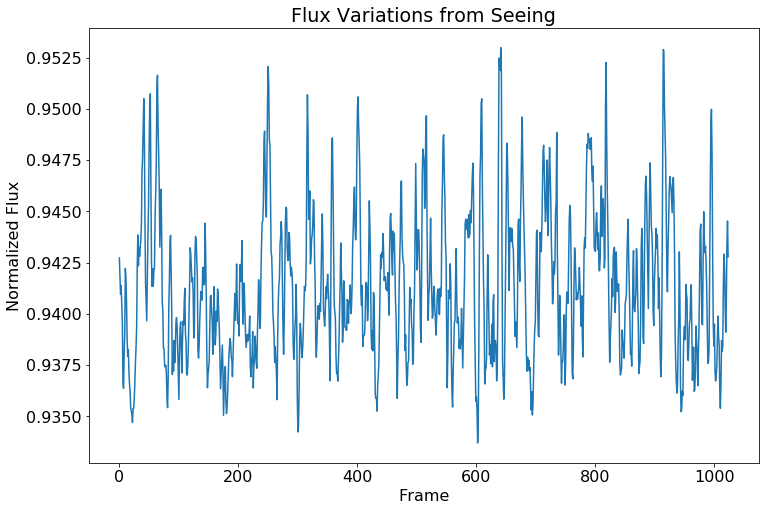

In [13]:
plt.plot((fluxes_meas))
plt.xlabel("Frame")
plt.ylabel("Normalized Flux")
plt.title("Flux Variations from Seeing")

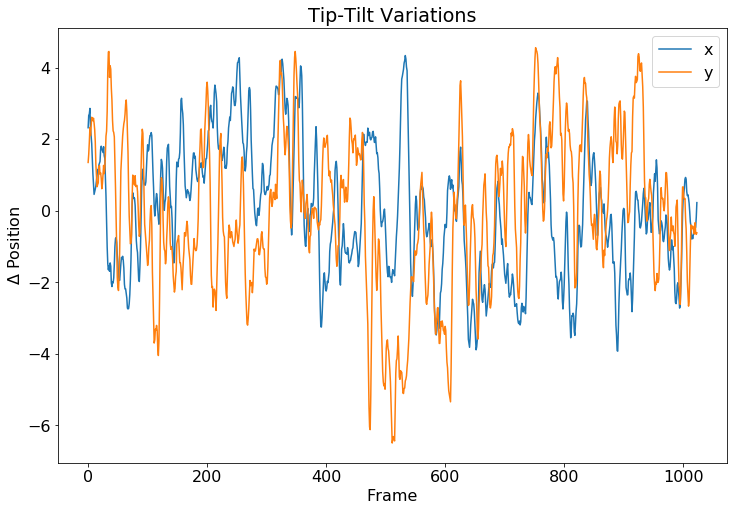

In [14]:
from scipy.ndimage.measurements import center_of_mass
xc, yc = np.zeros(images.shape[2]), np.zeros(images.shape[2])

for j in range(images.shape[2]):
    xc[j], yc[j] = center_of_mass(images[:,:,j])

plt.plot(xc-np.nanmedian(xc),label="x")
plt.plot(yc-np.nanmedian(yc),label="y")
plt.xlabel("Frame")
plt.ylabel(r'$\Delta$ Position')
plt.title('Tip-Tilt Variations')
plt.legend()

/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,u'Downscale')

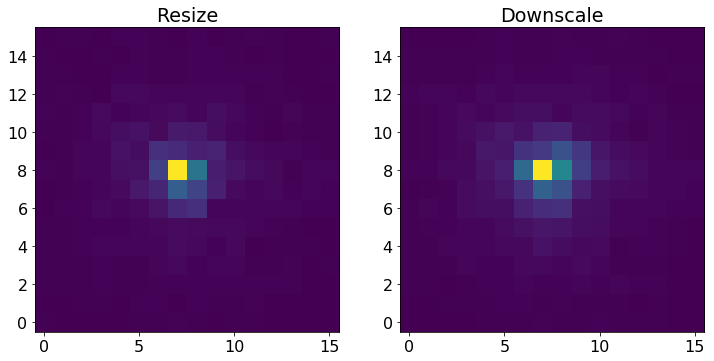

In [15]:
from skimage.transform import resize,downscale_local_mean
testframe = 170
test = resize(images[nx/4:3*nx/4,nx/4:3*nx/4,testframe], (16,16))
test2 = downscale_local_mean(images[nx/4:3*nx/4,nx/4:3*nx/4,testframe], (4,4))

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(test**0.5,interpolation="none")
ax1.set_title('Resize')

ax2.imshow(test2**0.5,interpolation="none")
ax2.set_title('Downscale')


## Now let's see how well we can do photometry with this time series.

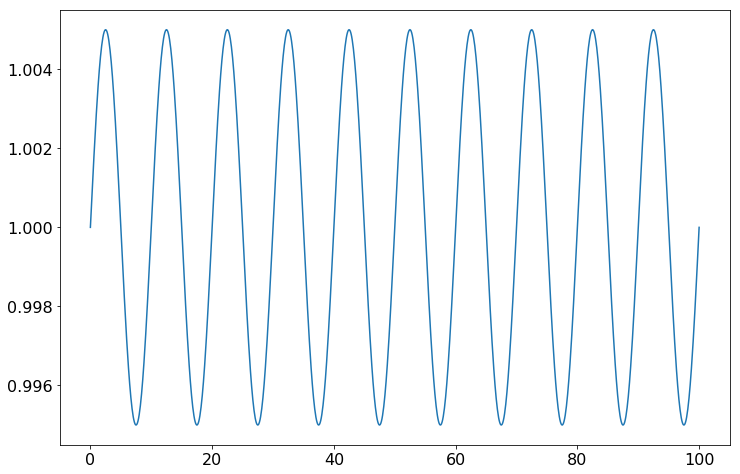

In [16]:
period = 10.

time = np.linspace(0,100,ncad)
flux = 1 + 0.005*np.sin(2*np.pi*time/period)

plt.plot(time,flux)

(16, 16, 1024)


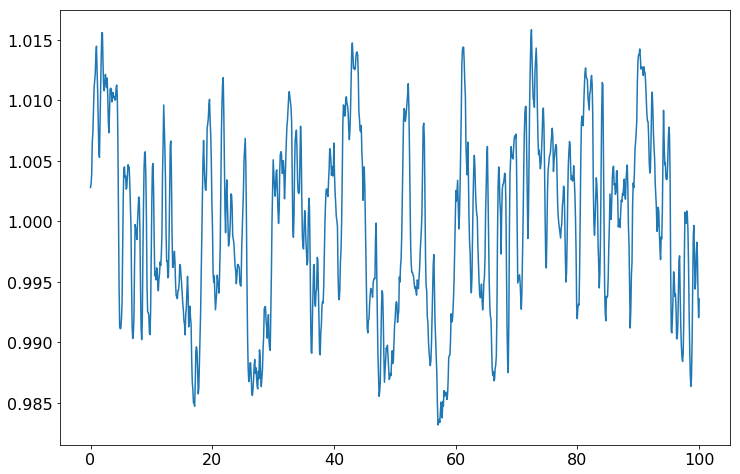

In [17]:
newnx, newny = 16, 16

sensitivity = 1 - 0.05*np.random.rand(newnx,newny)
tpf = sensitivity[:,:,np.newaxis] * flux * downscale_local_mean(psfs[nx/4:3*nx/4,nx/4:3*nx/4],(4,4,1))
print tpf.shape
pixelvectors = np.reshape(tpf,(newnx*newny,ncad))

raw_lc = np.sum(pixelvectors,axis=0)
raw_lc /= np.nanmedian(raw_lc)
plt.plot(time,raw_lc)

In [18]:
def obj_1(weights):
    flux = np.dot(weights.T,pixelvectors)
    return diff_1(flux)/np.nanmedian(flux)

In [19]:
cons = ({'type': 'eq', 'fun': lambda z: z.sum() - 1.})
npix = newnx*newny
bounds = (npix)*((0,1),)

w_init = np.random.rand(npix)
w_init /= np.sum(w_init)
# w_init = np.ones(180)/180.

res1 = optimize.minimize(obj_1, w_init, method='SLSQP', constraints=cons, bounds = bounds,
                        options={'disp': False})
xbest_1 = res1['x']

lc_opt_1 = np.dot(xbest_1.T,pixelvectors)
lc_opt_1 /= np.nanmedian(lc_opt_1)



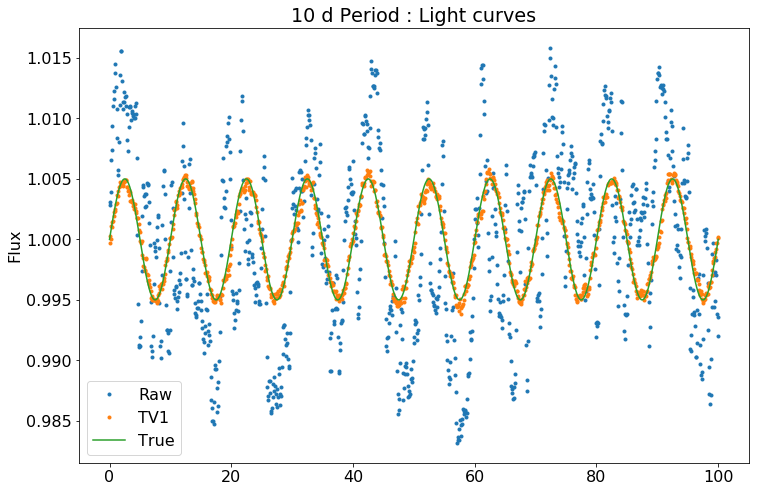

In [20]:
plt.plot(time,raw_lc,'.',label='Raw')
plt.plot(time,lc_opt_1,'.',label='TV1')
plt.plot(time,flux/np.nanmedian(flux),'-',label='True')
plt.ylabel('Time (d)')
plt.ylabel('Flux')
plt.title(r'%.1d d Period : Light curves' % period)
plt.legend()
# plt.savefig('period_%.0f_lc.png' % period)
plt.show()
